In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.colors as mcolors
import cartopy.feature as cfeature


In [87]:
def plot(values, scale):
    u, v, z, wind_speed, lon, lat = values

    # Custom white → blue → green → yellow → red colormap
    colors = ["white", "blue", "green", "yellow", "red"]
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_wbgr", colors, N=256)

    proj = ccrs.LambertConformal(central_longitude=-30, central_latitude=50)
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})
    ax.set_extent([-90, 30, 20, 75], crs=ccrs.PlateCarree())  # Covers N. America → Europe
    # Longitude: −90° to 30° (roughly from East Canada to Eastern Europe)

    # Latitude: 20° to 75° (Caribbean to Northern Europe)

    # Filled wind speed contours
    cf = ax.contourf(
        lon,
        lat,
        wind_speed,
        levels=20,
        cmap=custom_cmap,
        extend="max",
        alpha=0.3,
        transform=ccrs.PlateCarree(),
    )

    # Geopotential height contours
    cs = ax.contour(
        lon,
        lat,
        z,
        levels=20,
        colors="black",
        linewidths=0.8,
        transform=ccrs.PlateCarree(),
    )
    ax.clabel(cs, inline=True, fontsize=8, fmt="%d")

    # Wind vectors
    # lon_mesh, lat_mesh = np.meshgrid(lon, lat)
    ax.quiver(
        lon,
        lat,
        u,
        v,
        scale=scale,
        alpha=0.7,
        transform=ccrs.PlateCarree(),
    )

    # Map features
    ax.coastlines(resolution="50m", color="black", linewidth=0.8)
    ax.add_feature(cfeature.LAND, facecolor="#C69930", alpha=0.2)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.2)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}

    # Title & Colorbar
    # pressure_str = int(getattr(u, "pressure_level", 500))  # fallback if missing
    # plt.title(f"{pressure_str} hPa: Wind Speed (m/s), Geopotential Height (gpm)", fontsize=12)

    plt.colorbar(
        cf,
        ax=ax,
        orientation="horizontal",
        pad=0.05,
        label="Wind Speed (m/s)",
        shrink=0.5,
    )
    plt.tight_layout
    plt.show()

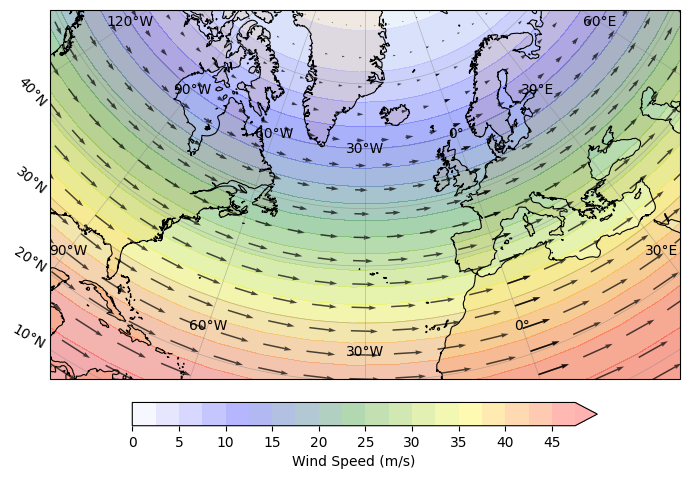

In [90]:
def zonal_wind(theta, phi):
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    # Latitude-dependent zonal wind (eastward)
    U0 = 50  # m/s, just for visible effect
    u = U0 * np.sin(theta_grid)**2
    v = np.zeros_like(u)

    # Convert to latitude and longitude in degrees
    lat = 90 - np.degrees(theta_grid)
    lon = np.degrees(phi_grid)

    # Compute wind speed
    wind_speed = np.sqrt(u**2 + v**2)

    # Use a representative geopotential field (e.g., idealized height)
    z = 5000  + 0 * np.sin(theta_grid)**2  # dummy field
    
    return u, v, z, wind_speed, lon, lat

theta = np.linspace(0, np.pi, 45)        # colatitude
phi = np.linspace(0, 2 * np.pi, 45)     # longitude

values = zonal_wind(theta, phi)
plot(values, scale=900)

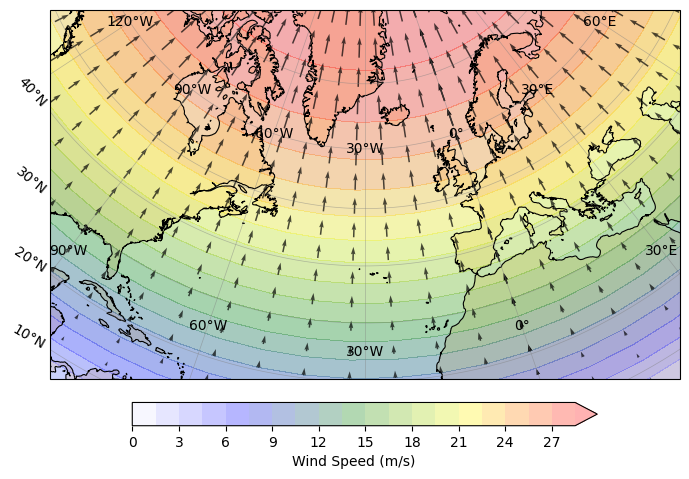

In [91]:
def meridional_wind(theta, phi):
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    # Latitude-dependent meridional wind (northward)
    V0 = 30  # m/s, just for visible effect
    v = V0 * np.cos(theta_grid)
    u = np.zeros_like(v)

    # Convert to latitude and longitude in degrees
    lat = 90 - np.degrees(theta_grid)
    lon = np.degrees(phi_grid)

    # Compute wind speed
    wind_speed = np.sqrt(u**2 + v**2)

    # Use a representative geopotential field (e.g., idealized height)
    z = 5000 + 0 * np.cos(theta_grid)  # dummy field
    
    return u, v, z, wind_speed, lon, lat

theta = np.linspace(0, np.pi, 45)        # colatitude
phi = np.linspace(0, 2 * np.pi, 45)     # longitude
values = meridional_wind(theta, phi)
plot(values, scale=900)

In [89]:
def coriolis_effect(theta, phi, steps=100, dt=100):
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    # Convert to latitude
    lat = 90 - np.degrees(theta_grid)
    lon = np.degrees(phi_grid)

    # Earth's rotation
    Omega = 7.2921e-5  # rad/s
    f = 2 * Omega * np.sin(np.radians(lat))  # Coriolis parameter at each lat

    # Initialize velocities (northward motion)
    v = np.full_like(f, 10.0)  # northward
    u = np.zeros_like(f)       # no zonal motion

    # Initialize displacements
    dx = np.zeros_like(f)
    dy = np.zeros_like(f)

    for _ in range(steps):
        # Update velocities using Coriolis force
        u_new = u + f * v * dt
        v_new = v - f * u * dt

        # Update positions
        dx += u_new * dt
        dy += v_new * dt

        # Advance state
        u, v = u_new, v_new

    # Optional wind speed
    wind_speed = np.sqrt(u**2 + v**2)

    # Dummy geopotential
    z = 5000 * np.ones_like(u)

    return u, v, z, wind_speed, lon, lat, dx, dy

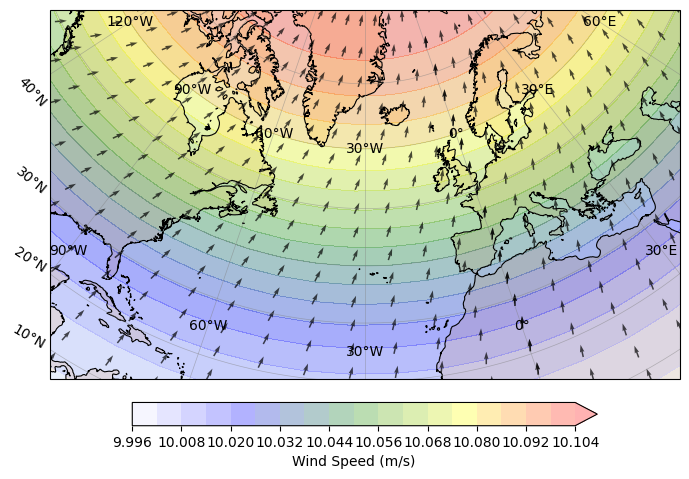

In [88]:
theta = np.linspace(0, np.pi, 45)        # colatitude
phi = np.linspace(0, 2 * np.pi, 45)     # longitude

# values = zonal_wind(theta, phi)
# values = meridional_wind(theta, phi)
u, v, z, wind_speed, lon, lat, dx, dy = coriolis_effect(theta, phi)
values = (dx, dy, z, wind_speed, lon, lat)
plot(values, scale=5000000)
